# Introduction to naive Bayes models

This notebook introduces you to naive Bayes models. Naive Bayes models are a surprisingly useful and effective simplification of the general Bayesian models. Naive Bayes models make the naive assumption of independence of the features.

Some properties of naive Bayes models are:

- Computational complexity is linear in number of parameter / features
- Require minimal data to produce models that generalizes well
- Have a simple and inherent regularization

Naive Bayes models are widely used including for:

- Document classification
- SPAM detection
- Image classification

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import naive_bayes
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

import matplotlib
matplotlib.rcParams['figure.figsize'] = [15, 5]

## Overview of naive Bayes models

Recall that by Bayes' theorem we have

$$P(C|X) = P(X|C) \frac{P(C)}{P(X)}$$

To make it easier, let's denote $C_k$ as the event of belonging to class $k$. And let $X$ be the data, which is better represented as a set of features $X_1, \ldots, X_n$. So we rewrite our equation as

$$P(C_k|X_1, \ldots, X_n) = P(X_1, \ldots, X_n|C_k) \frac{P(C_k)}{P(X_1, \ldots, X_n)}$$

Naive Bayes relies on two simple ideas:

1. It's easy to get $P(C_k)$ and $P(X_1, \ldots, X_n|C_k)$ from the data by just grouping the data by each class. So by using **Bayes' theorem**, we can then get $P(C_k|X_1, \ldots, X_n)$ which is what we're really after if we want to train a classifier.
2. Calculating $P(X_1, \ldots, X_n|C_k)$ can become challenging if we have many features, because some combinations of $X_1, \ldots, X_n|C_k$ might be very sparse. This can lead to overfitting. So we make a very **naive assumption**: we assume that the conditional probabilities of $X_1, \ldots, X_n$ are independent, so we can just take the product of the individual conditional probabilities. 

Let's illustrate the second idea with three features $X_1$, $X_2$ and $X_3$. Firstly, by the rules of probability, the join distribution of $X_1, X_2, X_3$ can be written as the product of conditional probabilities:

$$P(X_1, X_2, X_3) =  P(X_1 | X_2, X_3)  P(X_2, X_3) = p(X_1 | X_2, X_3)  p(X_2 | X_3) p(X_3)$$

Next we will condition everything by $C_k$ as well. This doesn't really change anything other than us adding $C_k$ to the right side of the probabilites.

$$P(X_1, X_2, X_3 | C_k) =  P(X_1 | X_2, X_3, C_k)  P(X_2, X_3 | C_k) = P(X_1 | X_2, X_3, C_k)  P(X_2 | X_3, C_k) P(X_3 | C_k)$$

We now assume **conditional independence** between any two features given the class, so that the only thing left on the right side of the probabilites is $C_k$:

$$P(X_1 | X_2, X_3, C_k)  P(X_2 | X_3, C_k) P(X_3 | C_k) = P(X_1 | C_k) P(X_2 | C_k) P(X_3 | C_k)$$

We can easily extend to this to $n$ features. So to summarize (1) and (2), we have:

$$P(C_k | X_1, X_2, X_3, \ldots, X_n) \propto P(C_k) \prod_{j = 1}^n P(X_j|C_k)$$

So the naive Bayes algorithm computes the right-hand-side for all classes and whichever class has the highest probability is the class we predict. In other words, 

$$\hat{Y} = \text{argmax}_k \prod_{j = 1}^n P(C_k)P(X_j|C_k)$$

Notice that the above formulation uses only the empirical probabilities of the features conditioned on the class. To compute the $P(X_j|C_k)$, we have several choices of probability distributions. When $X_j$ is categorical, a common choice is the **multinomial distribution**, which is an extension of the binomial distribution that works with any number of unique outcomes (not just 2). In this case, we call the model a **multinomial naive Bayes**. When $X_j$ is numeric, a common choice is to use the normal distribution: the result is called **Gaussian naive Bayes**.

There are some well known issues with naive Bayes with known solutions, including:

- Multiplication of small probabilities leads to floating point underflow. This problem is corrected by computing with the log probabilities.
- If there are no samples/data then $P(X_j|C_k) = 0$, leading the product of probabilities to be 0. A Laplace smoother is used to ensure that all $P(X_.j|C_k) > 0$.
- Collinear features do not exhibit independence. Ideally, such features should be removed from the the data set to prevent problems with the  model.
- Regularization is generally a minor issue with naive Bayes models, as uninformative features tend to a uniform distribution which does not affect the outcome.

## Example - income prediction using Census data

Let's try a binary classification example on some sample US Census data. We want to build and evaluate a naive Bayes model to classify people by high and low income using $50,000 as the cut-off. Execute this code and examine the features in the data set. 

In [2]:
census_URL = 'https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/Adult%20Census%20Income%20Binary%20Classification%20dataset.csv'
census = pd.read_csv(census_URL, sep = ',\\s+', engine = 'python')
census.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
census.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


We can see some features which are likely to be collinear. There is also one feature, `fnlwgt`, which is not useful in classifying these people. We also convert all columns of type `object` into type `category`.

In [4]:
census = census.drop(columns = ['workclass', 'fnlwgt', 'education-num', 'relationship'])
census[census.select_dtypes('object').columns] = census.select_dtypes('object').astype('category')
census.head()

,age,education,marital-status,occupation,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,Bachelors,Never-married,Adm-clerical,White,Male,2174,0,40,United-States,<=50K
1,50,Bachelors,Married-civ-spouse,Exec-managerial,White,Male,0,0,13,United-States,<=50K
2,38,HS-grad,Divorced,Handlers-cleaners,White,Male,0,0,40,United-States,<=50K
3,53,11th,Married-civ-spouse,Handlers-cleaners,Black,Male,0,0,40,United-States,<=50K
4,28,Bachelors,Married-civ-spouse,Prof-specialty,Black,Female,0,0,40,Cuba,<=50K


Let's compute a naive Bayes model to classify `income` using the features in the Income data set. Since we have a mix of categorical and numeric features, we need to train two separate naive Bayes classifiers and then combine their results at the end.

In [5]:
features_num = census.select_dtypes('int64')
features_cat = census.drop(columns = ['income']).select_dtypes('category').apply(lambda x: x.cat.codes)
# X = pd.concat([features_num, features_cat], axis = 1)
Y = census['income'].cat.codes

We can now train our classifier. Read [here](https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes) about the hyper-parameters of the naive Bayes classifier. Since we have a mix of categorical and numeric features, we train a separate classifier on the categorical features and numeric features. We will later combine them.

In [6]:
mnb = naive_bayes.CategoricalNB()
mnb.fit(features_cat, Y)

gnb = naive_bayes.GaussianNB()
gnb.fit(features_num, Y)

GaussianNB()

Although naive Bayes can be a good classifier, it is not necessarily a good estimator, so the soft predictions obtained from `predict_proba` should be viewed with caution. So we should not be too eager in interpreting the soft predictions as probabilities, but we can definitely compare them across the different categories to see each category's contribution to the final (posterior) probability. Here we can see that for the categories of `education`.

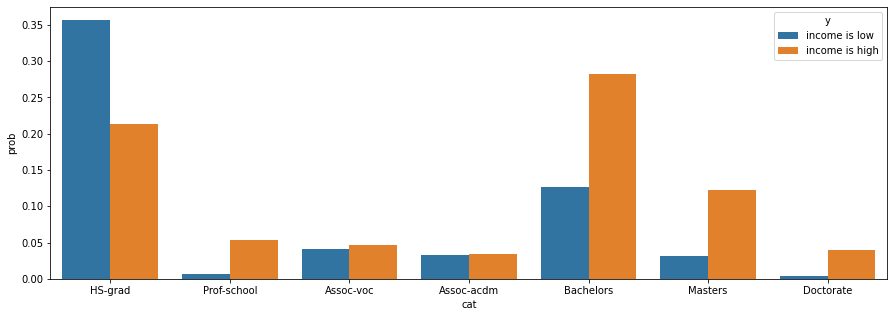

In [12]:
dd_0 = pd.DataFrame({'cat': census['education'].cat.categories, 'prob': np.exp(mnb.feature_log_prob_[0][0])})
dd_1 = pd.DataFrame({'cat': census['education'].cat.categories, 'prob': np.exp(mnb.feature_log_prob_[0][1])})
dd_0['y'] = 'income is low'
dd_1['y'] = 'income is high'
dd = dd_0.append(dd_1)

# let's keep only the relevant categories and order them in a way that makes sense
cat_order = ['HS-grad', 'Prof-school', 'Assoc-voc', 'Assoc-acdm', 'Bachelors', 'Masters', 'Doctorate']
dd['cat'] = dd['cat'].astype('category').cat.set_categories(cat_order)

bar = sns.barplot(x = 'cat', y = 'prob', data = dd, hue = 'y');

For the numeric feature, we can try to visualize the results by looking at how the posterior probabilities change as a result of changing one variable (holding the others constant at their average values).

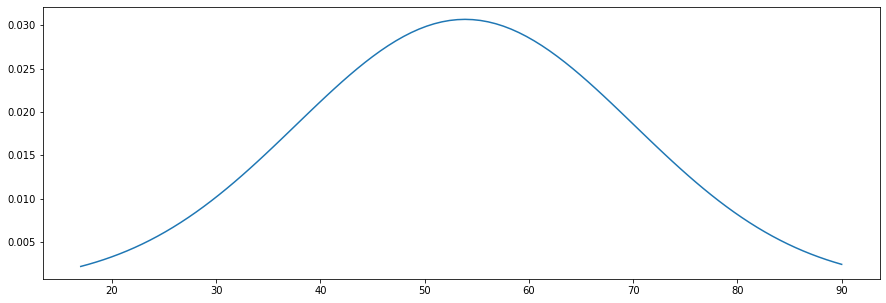

In [14]:
# Crazy block of code... holds all other features constant, but then lets age vary from it's max to min
age_min, age_max = features_num.describe()['age'][['min', 'max']]
age_range = np.linspace(age_min, age_max, num = 50)
dd = pd.DataFrame({'age': age_range})

dd['capital-gain'] = features_num['capital-gain'].mean()
dd['capital-loss'] = features_num['capital-loss'].mean()
dd['hours-per-week'] = features_num['hours-per-week'].mean()

sns.lineplot(x = age_range, y = gnb.predict_proba(dd)[:, 1]);

If we had only one model, then we can obtain hard predictions by calling its `predict` model and get soft predictions by calling `predict_prob`. We can also indirectly obtain hard predictions by using `np.argmax` on the soft predictions.

Since we need to combine both models into one, we need to do obtain hard predictions manually: 
- First we get soft predictions by taking the the product of each model's soft predictions (probabilities). Or in log terms, we add the log probabilites.
- Finally we use `np.argmax` to get hard predictions from the soft predictions.

In [15]:
combined_preds = mnb.predict_log_proba(features_cat) + gnb.predict_log_proba(features_num)
combined_preds.shape
census['pred_income_high'] = np.argmax(combined_preds, axis = 1)

census.groupby('pred_income_high').mean()

,age,capital-gain,capital-loss,hours-per-week
pred_income_high,,,,
0,37.908703,53.277810,7.370276,39.871909
1,44.205172,9637.917241,755.277299,45.163506


Let's look at the model accuracy.

In [16]:
accuracy_score(census['income'] == '>50K', census['pred_income_high'])

0.803845090752741

How good a model is this? We leave it to the reader to try other performance measure or even try another model like logistic regression for comparison.

### Document classification with naive Bayes

Document classification has been one of the most successful applications of the naive Bayes model. There is a good chance that the SPAM filter your email service uses is a naive Bayes model, at least in part.

We say that we classify documents by **topics**. The naive Bayes topic model computes the probability that a document $D$ has topic $C$ based on the occurrence of the words $\{ w_1, w_2, \ldots, w_n \}$, using the following relationship:

$$p(C|D) \propto \prod_{j = 1}^N p(w_j|C)$$

Notice that this topic model allows a document to have a number of topics. For example, we can say the topics of $D$ are the 5 topics with the highest probability.

For a SPAM classifier, the topics are just spam and not spam, so we only need a Bernoulli topic model:

$$p(S+|D) \propto p(S+) \prod_{j=1}^N p(w_j|S+)$$

### Exercise

Let's try a simple example: Consider the `HouseVotes84` data which contains political party and votes on 16 important bills for 435 members of the US House of Representatives in 1984. We will use this data set to build and test a classifier to predict the political party of representatives.

In [2]:
vote_names = [
    'handicapped_infants',
    'water_project_cost_sharing',
    'adoption_of_the_budget_resolution',
    'physician_fee_freeze',
    'el_salvador_aid',
    'religious_groups_in_schools',
    'anti_satellite_test_ban',
    'aid_to_nicaraguan_contras',
    'mx_missile',
    'immigration',
    'synfuels_corporation_cutback',
    'education_spending',
    'superfund_right_to_sue',
    'crime',
    'duty_free_exports',
    'export_administration_act_south_africa']

votes = pd.read_csv('https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/house-votes-84.csv', 
                    header = None, names = ['party'] + vote_names)
print(votes.shape)
votes.head()

(435, 17)


,party,handicapped_infants,water_project_cost_sharing,adoption_of_the_budget_resolution,physician_fee_freeze,el_salvador_aid,religious_groups_in_schools,anti_satellite_test_ban,aid_to_nicaraguan_contras,mx_missile,immigration,synfuels_corporation_cutback,education_spending,superfund_right_to_sue,crime,duty_free_exports,export_administration_act_south_africa
0,republican,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
2,democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y


- Reshape the data from wide to long, so the new data called `votes_long` has only three columns: `party`, `issue` and `vote`. HINT: You can use the `melt` method to reshape the data.

In [3]:
#pd.melt(df, id_vars=['A'], value_vars=['B'])
#pd.melt(df,id_vars=['countries'],var_name='metrics', value_name='values')
votes_long = pd.melt(votes, id_vars = ['party']).rename(columns = {'variable' : 'issue', 'value': 'vote'})
votes_long.head()

,party,issue,vote
0,republican,handicapped_infants,n
1,republican,handicapped_infants,n
2,democrat,handicapped_infants,?
3,democrat,handicapped_infants,n
4,democrat,handicapped_infants,y


In [7]:
votes_long = pd.melt(votes, id_vars = ['party'])
votes_long.tail(30)

,party,variable,value
6930,republican,export_administration_act_south_africa,y
6931,democrat,export_administration_act_south_africa,y
6932,democrat,export_administration_act_south_africa,n
6933,democrat,export_administration_act_south_africa,y
6934,republican,export_administration_act_south_africa,n
6935,republican,export_administration_act_south_africa,y
6936,democrat,export_administration_act_south_africa,y
6937,republican,export_administration_act_south_africa,y
6938,republican,export_administration_act_south_africa,y
6939,democrat,export_administration_act_south_africa,y


- Visualize the data by looking at a barplot of the frequency of votes by party for each issue. We have the right template for the plot here. So just fill in the features.

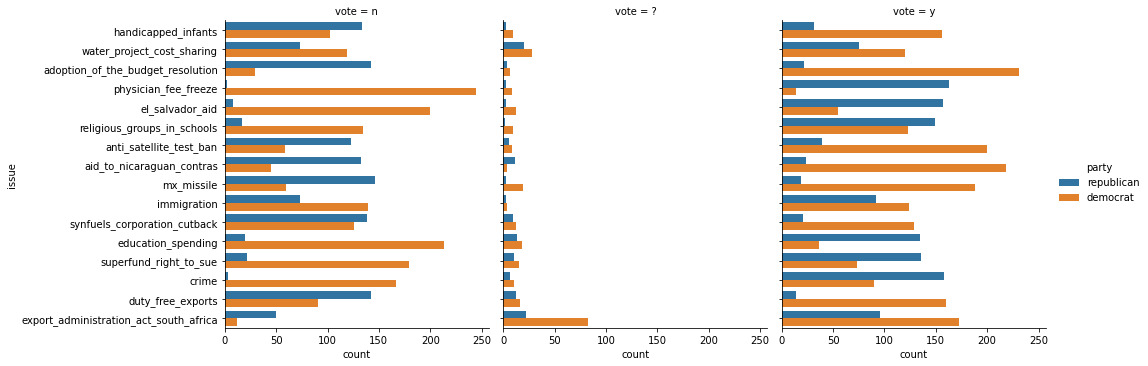

In [61]:
sns.catplot(y = "issue", hue = "party", col = "vote", data = votes_long, kind = "count");

- Return to the wide data `votes`: Loops though the columns `vote_names` and perform the following:
  - Convert the columns into type `category` and limit the categories to `y` and `n`. What happens with all the `?` votes?
  - If there are missing values in these columns, replace the missing values with the majority vote **by party affiliation**. HINT: To look at an example, run `votes.groupby('party')['immigration'].transform(lambda x: x.fillna(x.mode()[0]))`.
  - Replace a `yes` vote with 1 and a `no` vote with 0 (`sklearn` doesn't like string columns).

In [62]:
votes.groupby('party')['immigration'].transform(lambda x: x.fillna(x.mode()[0]))

0      y
1      n
2      n
3      n
4      n
      ..
430    y
431    y
432    n
433    ?
434    y
Name: immigration, Length: 435, dtype: object

In [63]:
cols = list(votes.columns)
# remove party
cols.remove('party')

for c in cols:
    # convert everything to a category
    votes[c] = votes[c].astype('category').cat.set_categories(['y', 'n'])
    # Group by the party and subject area, then replace with the mod for that group by
    votes[c] = votes.groupby('party')[c].transform(lambda x: x.fillna(x.mode()[0]))
    # replace the y with 1, n with 0
    votes[c] = votes[c].replace({'y': 1, 'n': 0})                                              

votes.head()
    

,party,handicapped_infants,water_project_cost_sharing,adoption_of_the_budget_resolution,physician_fee_freeze,el_salvador_aid,religious_groups_in_schools,anti_satellite_test_ban,aid_to_nicaraguan_contras,mx_missile,immigration,synfuels_corporation_cutback,education_spending,superfund_right_to_sue,crime,duty_free_exports,export_administration_act_south_africa
0,republican,0,1,0,1,1,1,0,0,0,1,0,1,1,1,0,1
1,republican,0,1,0,1,1,1,0,0,0,0,0,1,1,1,0,1
2,democrat,1,1,1,0,1,1,0,0,0,0,1,0,1,1,0,0
3,democrat,0,1,1,0,0,1,0,0,0,0,1,0,1,0,0,1
4,democrat,1,1,1,0,1,1,0,0,0,0,1,0,1,1,1,1


- Make sure that no NAs are left in the data.

In [64]:
votes.isna().sum()

party                                     0
handicapped_infants                       0
water_project_cost_sharing                0
adoption_of_the_budget_resolution         0
physician_fee_freeze                      0
el_salvador_aid                           0
religious_groups_in_schools               0
anti_satellite_test_ban                   0
aid_to_nicaraguan_contras                 0
mx_missile                                0
immigration                               0
synfuels_corporation_cutback              0
education_spending                        0
superfund_right_to_sue                    0
crime                                     0
duty_free_exports                         0
export_administration_act_south_africa    0
dtype: int64

Time to train a classifier to predict party affiliation based on how someone votes on the above issues. The model will predict the probability of being a Democrat. For simplicity, we assume that the probability of being a Republican is 1 minus that of being a Democrat.

- Train a multinomial naive Bayes classifier to predict whether someone is a Democrat based on their vote. To keep things simple, you do NOT need to split the data into training and testing.

In [69]:
X = votes[cols]
Y = votes['party'] =='democrat'

mnb = naive_bayes.MultinomialNB()
mnb.fit(X, Y)

MultinomialNB()

- Create a new column in the data called `pred_party` and store the model's predicted party affilation in it. Note that you will need to express the predictions in terms of party affiliation: `democrat` or `republican`.

In [78]:
votes['pred_party'] = mnb.predict(X)
votes['pred_party'] = votes['pred_party'].replace({False: 'republican', True: 'democrat'})
votes['error'] = votes['party'] == votes['pred_party']
votes['error'] = votes['error'].replace({True: 0, False: 1})

votes.head()

,party,handicapped_infants,water_project_cost_sharing,adoption_of_the_budget_resolution,physician_fee_freeze,el_salvador_aid,religious_groups_in_schools,anti_satellite_test_ban,aid_to_nicaraguan_contras,mx_missile,immigration,synfuels_corporation_cutback,education_spending,superfund_right_to_sue,crime,duty_free_exports,export_administration_act_south_africa,pred_party,correct_prediction,error
0,republican,0,1,0,1,1,1,0,0,0,1,0,1,1,1,0,1,republican,True,0
1,republican,0,1,0,1,1,1,0,0,0,0,0,1,1,1,0,1,republican,True,0
2,democrat,1,1,1,0,1,1,0,0,0,0,1,0,1,1,0,0,democrat,True,0
3,democrat,0,1,1,0,0,1,0,0,0,0,1,0,1,0,0,1,democrat,True,0
4,democrat,1,1,1,0,1,1,0,0,0,0,1,0,1,1,1,1,democrat,True,0


- Run the cell below to get the accuracy and confusion matrix. If you get an error, you probably missed a step above.

In [79]:
print('accuracy: {:.2f}'.format(accuracy_score(votes['party'], votes['pred_party'])))
print('confusion matirx normalized by actual affiliation (dem, rep):')
print(confusion_matrix(votes['party'], votes['pred_party'], labels = ['democrat', 'republican'], normalize = 'true'))

accuracy: 0.91
confusion matirx normalized by actual affiliation (dem, rep):
[[0.90262172 0.09737828]
 [0.06547619 0.93452381]]


/Users/roblisy/.pyenv/versions/3.7.0/envs/uw_data_sci/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()
/Users/roblisy/.pyenv/versions/3.7.0/envs/uw_data_sci/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':


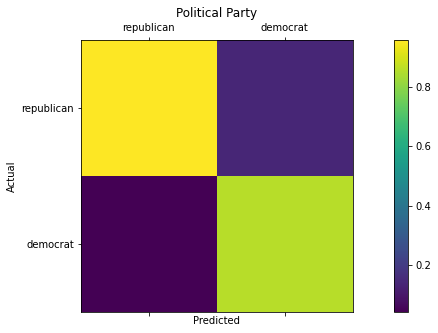

[[0.95634921 0.1420765 ]
 [0.04365079 0.8579235 ]]


In [80]:
# store class labels, and (normalized) confusion matrix
labels = ['republican', 'democrat']
cm = confusion_matrix(votes['party'], votes['pred_party'], normalize = "pred")

# configure confusion matrix plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Political Party')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
# show plot and confusion matrix
plt.show()
print(cm)

### End of exercise

## Summary

In this notebook we learned how a the naive Bayes classifier relies on the Bayes' theorem and the "naive assumption" to predict classes. Despite the fact that the assumption of independence is pretty "naive" in some cases (such as our problem of predicting party affiliation), our classifier did a pretty good job overall. This shows that in machine learning we really don't know until we try. Just like logistic regression, the naive Bayes classifier is an efficient algorithm for scoring, which makes it a good candidate for applications where efficiency really matters.